In [32]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

In [33]:
import numpy as np
import pandas as pd

In [34]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [35]:
# Python SQL toolkit and Object Relational Mapper
#import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func,inspect,distinct,desc

In [36]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [37]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [38]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [39]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [40]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

1.....last_date2017-08-23
2.....2017-08-23 00:00:00
3.....2016-08-23 00:00:00
date_query 2016-08-23
count before na precipitation    2021
date             2230
dtype: int64
count :precipitation    2021
dtype: int64


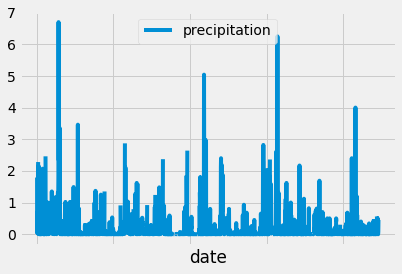

In [41]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

# Calculate the date 1 year ago from the last data point in the database
#get the max date in the DB
last_date =session.query(Measurement.date).order_by(Measurement.date.desc()).first()
last_date=str(last_date) #('2017-08-23',)
#strip ('',)
last_date=last_date[2:-3]
type(last_date)
print(f"1.....last_date{last_date}")
#convert into datetime object
ldate =dt.datetime.strptime(last_date,'%Y-%m-%d')
print(f"2.....{ldate}")
#get 1 year from he last date in the DB
date_query=ldate-dt.timedelta(days=365)
print(f"3.....{date_query}")
date_query =dt.datetime.strftime(date_query,'%Y-%m-%d')


print(f"date_query {date_query}")



# Perform a query to retrieve the data and precipitation scores
result = session.query(Measurement.prcp,Measurement.date).filter(Measurement.date >= date_query).all()
#print(result)
# Save the qery results as a Pandas DataFrame and set the index to the date column
df = pd.DataFrame(result[::],columns=['precipitation','date'])

print(f"count before na {df.count()}")
#df = df.dropna(how='any',inplace=True)
df.set_index('date',inplace=True)
df.head()
print(f"count :{df.count()}")
# Sort the dataframe by date
df=df.sort_values(by=['date'])
df.head()
# Use Pandas Plotting with Matplotlib to plot the data
df.plot()
plt.tick_params(labelbottom=False)
plt.legend(loc='upper center')
plt.show()


![precipitation](Images/precipitation.png)

In [42]:
# Use Pandas to calcualte the summary statistics for the precipitation data
df.describe()

,precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


![describe](Images/describe.png)

In [43]:
# Design a query to show how many stations are available in this dataset?
#get the columns name of the station table
inspector =inspect(engine)
inspector.get_table_names()
col_station =inspector.get_columns('station')
col_station
#session.query(func.count(distinct(User.name)))
count_satations = session.query(Station.name).distinct().count()
print(f"There are {count_satations} distinct stations.")

There are 9 distinct stations.


In [44]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
inspector =inspect(engine)
inspector.get_table_names()
col_measurement =inspector.get_columns('measurement')
col_measurement
session.query(Measurement.station,func.count(Measurement.station).label("NumStation")).\
group_by(Measurement.station).\
order_by(desc('NumStation')).all()

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [45]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
session.query(func.min(Measurement.tobs),func.max(Measurement.tobs),func.avg(Measurement.tobs)).filter(Measurement.station =='USC00519281').all()

[(54.0, 85.0, 71.66378066378067)]

[]

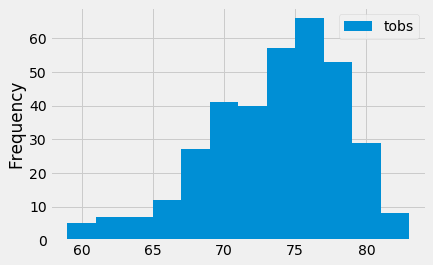

In [46]:
# Choose the station with the highest number of temperature observations.

# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
results = session.query(Measurement.tobs).filter(Measurement.date >= date_query).\
filter(Measurement.station =='USC00519281').all()

#print(results)


#make a dataframe out of it
df_temp = pd.DataFrame(results,columns=['tobs'])
df_temp.dropna(how='any',inplace=True)
df_temp.sort_values(by='tobs',inplace=True)
df_temp.head()
plt=df_temp.plot.hist(bins=12)
 
plt.plot()

# = df.plot.hist(bins=12, alpha=0.5)

![precipitation](Images/station-histogram.png)

In [47]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [48]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
#print(calc_temps('2016-08-14', '2017-08-27'))
trip_start_date=dt.date(2016, 8,14)
trip_end_date=dt.date(2016, 8, 27)

print(trip_start_date)
print(trip_end_date)
trip =(calc_temps(trip_start_date, trip_end_date))
print(trip)
    



2016-08-14
2016-08-27
[(72.0, 78.16666666666667, 84.0)]


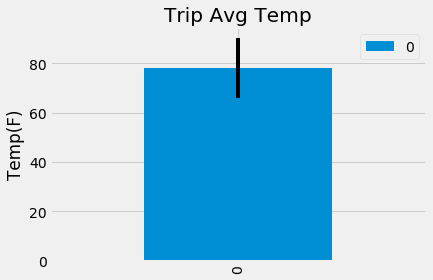

In [49]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)

tmin = trip[0][0]
tavg = trip[0][1]
tmax = trip[0][2]

import pandas as pd 
import matplotlib.pyplot as plt

df3 = pd.DataFrame([tavg])
yerror=tmax-tmin
df3.plot(kind='bar',yerr=yerror)     
plt.title("Trip Avg Temp")
plt.ylabel("Temp(F)")
plt.show()



# RainFall

In [50]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation

#select sum(measurement.prcp),station.name,station.elevation,station.latitude,station.longitude from measurement,station
#GROUP by (measurement.station) WHERE measurement.date >

#group_by(station).filter(date> date<)
#order

rainfall = session.query(func.sum(Measurement.prcp),Station.name,Station.elevation,Station.latitude,Station.longitude).\
filter(Measurement.date >= trip_start_date).filter(Measurement.date <= trip_end_date).\
filter(Measurement.station == Station.station).\
group_by(Measurement.station).order_by(Measurement.prcp).all()


print(rainfall)

[(2.4699999999999998, 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 7.0, 21.5213, -157.8374), (0.04, 'PEARL CITY, HI US', 11.9, 21.3934, -157.9751), (0.72, 'WAIKIKI 717.2, HI US', 3.0, 21.2716, -157.8168), (2.26, 'WAIMANALO EXPERIMENTAL FARM, HI US', 19.5, 21.33556, -157.71139), (7.73, 'WAIHEE 837.5, HI US', 32.9, 21.45167, -157.84888999999998), (4.46, 'KANEOHE 838.1, HI US', 14.6, 21.4234, -157.8015), (10.099999999999998, 'MANOA LYON ARBO 785.2, HI US', 152.4, 21.3331, -157.8025)]


## Optional Challenge Assignment

# Temp2

In [51]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [52]:
# calculate the daily normals for your trip
from datetime import timedelta
# Set the start and end date of the trip
trip_start_date=dt.date(2016, 8,14)
trip_end_date=dt.date(2016, 8, 27)
# push each tuple of calculations into a list called `normals`
normals_tmin=[]
normals_tavg=[]
normals_tmax=[]
date_range=[str(trip_start_date)]
md_strip=[]
#tobs_list =list(np.ravel(results))




# Use the start and end date to create a range of dates
# Stip off the year and save a list of %m-%d strings
md_strip.append(trip_start_date.strftime("%m-%d"))
#date_range.append(trip_start_date)

while trip_start_date < trip_end_date:
    trip_start_date = trip_start_date + timedelta(days=1) 
    print(trip_start_date)
    date_range.append(str(trip_start_date))
    
    md_strip.append(trip_start_date.strftime("%m-%d"))
    
print(date_range)
print(md_strip)
# Loop through the list of %m-%d strings and calculate the normals for each date
for i in md_strip:
    #normals.append(list(np.ravel(daily_normals(i))))
    r=list(np.ravel(daily_normals(i)))  
    normals_tmin.append(r[0])
    normals_tavg.append(r[1])
    normals_tmax.append(r[2])
    #print(r[0])
    #print(r[1])
    #print(r[2])

    
print(normals_tmin)
print(normals_tavg)
print(normals_tmax)


2016-08-15
2016-08-16
2016-08-17
2016-08-18
2016-08-19
2016-08-20
2016-08-21
2016-08-22
2016-08-23
2016-08-24
2016-08-25
2016-08-26
2016-08-27
['2016-08-14', '2016-08-15', '2016-08-16', '2016-08-17', '2016-08-18', '2016-08-19', '2016-08-20', '2016-08-21', '2016-08-22', '2016-08-23', '2016-08-24', '2016-08-25', '2016-08-26', '2016-08-27']
['08-14', '08-15', '08-16', '08-17', '08-18', '08-19', '08-20', '08-21', '08-22', '08-23', '08-24', '08-25', '08-26', '08-27']
[71.0, 69.0, 69.0, 69.0, 70.0, 69.0, 68.0, 67.0, 69.0, 67.0, 70.0, 69.0, 71.0, 68.0]
[76.77777777777777, 76.47169811320755, 76.08, 76.125, 76.92307692307692, 75.94642857142857, 76.45283018867924, 76.4, 76.47169811320755, 76.6923076923077, 75.96153846153847, 76.96078431372548, 76.56862745098039, 76.28301886792453]
[82.0, 83.0, 83.0, 83.0, 84.0, 85.0, 82.0, 83.0, 84.0, 87.0, 84.0, 82.0, 84.0, 84.0]


In [53]:
"""
# Stip off the year and save a list of %m-%d strings
md_strip=[]
a=dt.datetime
for d in range(0,len(date_range)):
    #year_strip.append
    dd =dt.datetime.strftime(str(date_range[d]),'%Y-%m-%d')
    md_strip.append(dd.strptime("%m-%d"))
    print(dd)
    
print(md_strip)    
"""
# Loop through the list of %m-%d strings and calculate the normals for each date

#ldate =dt.datetime.strptime(last_date,'%Y-%m-%d')

#ldate =datetime.datetime.strptime('2016-08-15','%Y-%m-%d')
#print(ldate.strftime("%m-%d"))
[[71.0, 76.77777777777777, 82.0], [69.0, 76.47169811320755, 83.0], [69.0, 76.08, 83.0], [69.0, 76.125, 83.0], [70.0, 76.92307692307692, 84.0], [69.0, 75.94642857142857, 85.0], [68.0, 76.45283018867924, 82.0], [67.0, 76.4, 83.0], [69.0, 76.47169811320755, 84.0], [67.0, 76.6923076923077, 87.0], [70.0, 75.96153846153847, 84.0], [69.0, 76.96078431372548, 82.0], [71.0, 76.56862745098039, 84.0], [68.0, 76.28301886792453, 84.0]]

[[71.0, 76.77777777777777, 82.0],
 [69.0, 76.47169811320755, 83.0],
 [69.0, 76.08, 83.0],
 [69.0, 76.125, 83.0],
 [70.0, 76.92307692307692, 84.0],
 [69.0, 75.94642857142857, 85.0],
 [68.0, 76.45283018867924, 82.0],
 [67.0, 76.4, 83.0],
 [69.0, 76.47169811320755, 84.0],
 [67.0, 76.6923076923077, 87.0],
 [70.0, 75.96153846153847, 84.0],
 [69.0, 76.96078431372548, 82.0],
 [71.0, 76.56862745098039, 84.0],
 [68.0, 76.28301886792453, 84.0]]

In [54]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
normal_df =pd.DataFrame({"date":date_range,
                          "tmin":  normals_tmin,
                         "tavg":  normals_tavg,
                         "tmax":  normals_tmax
                         
                        }).set_index("date")
normal_df.head()

,tmin,tavg,tmax
date,,,
2016-08-14,71.0,76.777778,82.0
2016-08-15,69.0,76.471698,83.0
2016-08-16,69.0,76.080000,83.0
2016-08-17,69.0,76.125000,83.0
2016-08-18,70.0,76.923077,84.0


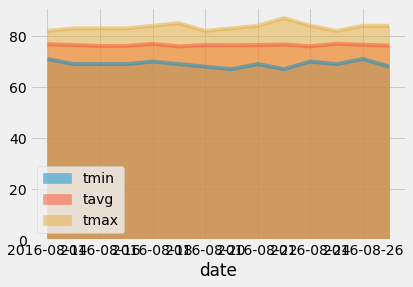

In [55]:
# Plot the daily normals as an area plot with `stacked=False`
#ax = normal_df.plot.area(stacked=False)

normal_df.plot.area(stacked=False)

#plt.gca().invert_xaxis()
#plt.show()